In [1]:
import os
from typing import Any

from PIL import Image
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets import CocoDetection
from torch.utils.data.dataloader import DataLoader

In [2]:
import torchvision
from torchvision import datasets
from torchvision.transforms import v2
import torchvision.tv_tensors

transform = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomPhotometricDistort(p=1),
        v2.RandomZoomOut(fill={torchvision.tv_tensors.Image: (123, 117, 104), "others": 0}),
        v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.CocoDetection('../coco/images/train2017/', '../coco/annotations/instances_train2017.json', transforms=transform)

loading annotations into memory...
Done (t=7.29s)
creating index...
index created!


In [3]:
dataset = datasets.wrap_dataset_for_transforms_v2(dataset,  target_keys=["boxes", "labels"])

In [4]:
sample = dataset[0]
sample

(Image([[[0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.3686, 0.2784, 0.2588],
         [0.0000, 0.0000, 0.0000,  ..., 0.3725, 0.3608, 0.2902],
         [0.0000, 0.0000, 0.0000,  ..., 0.4078, 0.3451, 0.2902]],
 
        [[0.0000, 0.0000, 0.0000,  ..., 0.3922, 0.4078, 0.4078],
         [0.0000, 0.0000, 0.0000,  ..., 0.3922, 0.4039, 0.4039],
         [0.0000, 0.0000, 0.0000,  ..., 0.3608, 0.3725, 0.3922],
         ...,
         [0.5569, 0.5216, 0.5098,  ..., 0.0000, 0.0000, 0.0000],
         [0.5255, 0.5373, 0.5216,  ..., 0.0000, 0.0000, 0.0000],
         [0.4863, 0.5059, 0.5255,  ..., 0.0000, 0.0000, 0.0000]],
 
        [[0.1922, 0.2196, 0.2392,  ..., 0.9176, 0.9255, 0.9176],
         [0.1765, 0.2157, 0.2314,  ..., 0.9176, 0.9176, 0.9255],
         [0.1529, 0.1843, 0.2078,  ..., 0.8902, 0.9059, 

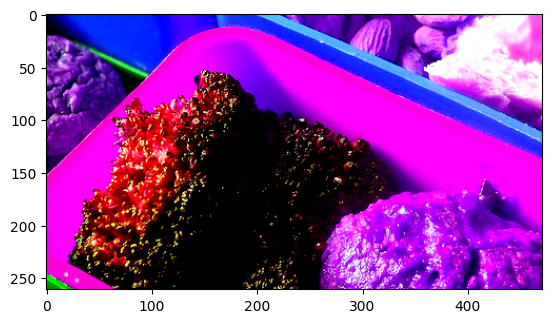

In [5]:
plt.imshow(transforms.functional.to_pil_image(sample[0]))

In [6]:
sample[1]

{'boxes': BoundingBoxes([[ -0.0000,   7.6900, 471.0000, 261.0000],
                [ 22.1600,  49.2700, 338.4000, 261.0000],
                [153.5200,   0.0000, 471.0000, 208.6300]], format=BoundingBoxFormat.XYXY, canvas_size=(261, 471)),
 'labels': tensor([51, 56, 51])}

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 80
# 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [8]:
# import utils
# from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 80 # use our dataset and defined transformations
#dataset = PennFudanDataset('/content/gdrive/MyDrive/PyTorch_Waterloo_Dataset/PunnFudanPed/PennFudanPed', get_transform(train=True))
#dataset_test = PennFudanDataset('/content/gdrive/MyDrive/PyTorch_Waterloo_Dataset/PunnFudanPed/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    # num_workers=4,
    collate_fn=lambda batch: tuple(zip(*batch))
)

"""
data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

"""
# get the model using our helper function
##odel = get_model_instance_segmentation(num_classes)

# move model to the right device
# model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 1

# for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    #train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    #lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader, device=device)


In [9]:
for imgs, targets in data_loader:
    # print(imgs)
    # imgs = imgs.to(device)
    # targets = targets.to(device)
    loss_dict = model(imgs, targets)
    # Put your training logic here

    print(f"{[img.shape for img in imgs] = }")
    print(f"{[type(target) for target in targets] = }")
    for name, loss_val in loss_dict.items():
        print(f"{name:<20}{loss_val:.3f}")
    break

[img.shape for img in imgs] = [torch.Size([3, 369, 224]), torch.Size([3, 1599, 1599])]
[type(target) for target in targets] = [<class 'dict'>, <class 'dict'>]
loss_classifier     4.401
loss_box_reg        0.175
loss_objectness     0.083
loss_rpn_box_reg    0.085


In [10]:
for epoch in range(num_epochs):
    

SyntaxError: incomplete input (1713755100.py, line 2)